# LENET MODEL for Classification with PyTorch


In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
import torch.optim as optim
from torch.utils.data import ConcatDataset, SubsetRandomSampler, DataLoader
from PIL import ImageFile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl -L -o THFOOD4.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Dataset/THFOOD4.zip
!unzip -o  THFOOD4.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  149M  100  149M    0     0  55.6M      0  0:00:02  0:00:02 --:--:-- 99.4M
Archive:  THFOOD4.zip
   creating: THFOOD4/GaengJued/
  inflating: THFOOD4/GaengJued/001.jpg  
  inflating: THFOOD4/GaengJued/002.jpg  
  inflating: THFOOD4/GaengJued/003.jpg  
  inflating: THFOOD4/GaengJued/004.jpg  
  inflating: THFOOD4/GaengJued/005.jpg  
  inflating: THFOOD4/GaengJued/006.jpg  
  inflating: THFOOD4/GaengJued/007.jpg  
  inflating: THFOOD4/GaengJued/008.jpg  
  inflating: THFOOD4/GaengJued/009.jpg  
  inflating: THFOOD4/GaengJued/010.jpg  
  inflating: THFOOD4/GaengJued/011.jpg  
  inflating: THFOOD4/GaengJued/012.jpg  
  inflating: THFOOD4/GaengJued/013.jpg  
  inflating: THFOOD4/GaengJued/015.jpg  
  inflating: THFOOD4/GaengJued/016.jpg  
  inflating: TH

In [ ]:
!unzip -q /content/test_set.zip -d /content/
!unzip -q /content/train_set.zip -d /content/

In [ ]:
# Utility
def copy_files_to_new_folders(original_dataset_dir, train_files, test_files, val_files):
    splits = [('train', train_files), ('test', test_files), ('val', val_files)]
    for split_name, files in splits:
        split_dir = os.path.join(original_dataset_dir, split_name)
        for file_path in files:
            class_name = os.path.basename(os.path.dirname(file_path))
            new_file_path = os.path.join(split_dir, class_name, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
            shutil.copyfile(file_path, new_file_path)

def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))

    return file_paths

def split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=42):
    train_files, test_files = train_test_split(file_paths, train_size=train_size, random_state=seed)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=seed)
    return train_files, test_files, val_files

def count_classes(file_list):
    class_counts = {}
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def center_crop_image(img, target_size=(64, 64)):
    new_dim = target_size[0] + 3

    if img.shape[1] > img.shape[0]:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_dim * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_dim))
    else:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_height = int(new_dim / aspect_ratio)
        resized_img = cv2.resize(img, (new_dim, new_height))

    width, height = resized_img.shape[1], resized_img.shape[0]
    crop_width = min(target_size[0], width)
    crop_height = min(target_size[1], height)
    mid_x, mid_y = width // 2, height // 2
    cw2, ch2 = crop_width // 2, crop_height // 2

    cropped_img = resized_img[mid_y - ch2: mid_y + ch2, mid_x - cw2: mid_x + cw2]

    return cropped_img

def prepare_data(dataset_dir,seed=42):
    file_paths = get_file_paths(dataset_dir)
    train_files, test_files, val_files = split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=seed)
    print("Training files:", len(train_files))
    print("Testing files:", len(test_files))
    print("Validation files:", len(val_files))
    train_counts = count_classes(train_files)
    test_counts = count_classes(test_files)
    val_counts = count_classes(val_files)
    print("Training files per class:", train_counts)
    print("Testing files per class:", test_counts)
    print("Validation files per class:", val_counts)
    return [train_files, test_files, val_files]

def explore(image_paths,center_crop=False):
    dataset_width = []
    dataset_height = []
    dataset_channels = []
    dataset_aspect_ratio = []
    avg_brightness_gray =[]
    avg_brightness_r = []
    avg_brightness_g = []
    avg_brightness_b = []

    for filename in image_paths:
        img = cv2.imread(filename)
        if center_crop:
            img = center_crop_image(img)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, c = img.shape
            dataset_width.append(w)
            dataset_height.append(h)
            dataset_channels.append(c)
            dataset_aspect_ratio.append(w / h)
            red = np.mean(img[...,0])
            avg_brightness_r.append(red)
            green = np.mean(img[...,1])
            avg_brightness_g.append(green)
            blue = np.mean(img[...,2])
            avg_brightness_b.append(blue)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            avg_brightness_gr = np.mean(gray)
            avg_brightness_gray.append(avg_brightness_gr)
    return dataset_width,dataset_height,dataset_channels,dataset_aspect_ratio,avg_brightness_gray,avg_brightness_r,avg_brightness_g,avg_brightness_b

def compute_max_values(datasets):
    max_width = max_height = max_aspect_ratio = max_brightness_gray = max_brightness_rgb = float('-inf')

    for dataset in datasets:
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset)

        max_width = max(max_width, max(dataset_width))
        max_height = max(max_height, max(dataset_height))
        max_aspect_ratio = max(max_aspect_ratio, max(dataset_aspect_ratio))
        max_brightness_gray = max(max_brightness_gray, max(avg_brightness_gray))
        max_brightness_rgb = max(max_brightness_rgb, max(avg_brightness_r), max(avg_brightness_g), max(avg_brightness_b))

    return max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb

def summary(dataset_dir,seed,center_crop=False):
    train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)
    max_len = 0
    for ele in [train_files, test_files, val_files]:
        max_len = max(max_len, len(ele))
    max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb = compute_max_values([train_files, test_files, val_files])

    row_labels = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(f'Dataset Exploration: Train, Test, and Validation Sets\nSEED: {seed}', fontsize=20, weight='bold')
    font_size = 6
    title_font_size = font_size + 2
    for index, dataset in enumerate([train_files, test_files, val_files]):
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset,center_crop=center_crop)

        ax[index, 0].scatter(dataset_width, dataset_height, marker='x',)
        ax[index, 0].plot([0, max_width+200], [0, max_width+200], color='red', label='aspect ratio = 1')
        ax[index, 0].legend(fontsize=font_size)
        ax[index, 0].set_xlim([0, max(max_width,max_height)+50])
        ax[index, 0].set_ylim([0, max(max_width,max_height)+50])
        ax[index, 0].tick_params(axis='both', labelsize=font_size)
        ax[index, 0].set_xlabel('Width', fontsize=font_size)
        ax[index, 0].set_ylabel('Height', fontsize=font_size)
        ax[index, 0].set_title('Scatter Plot of Dataset Width and Height', fontsize=font_size)

        ax[index, 1].hist(dataset_aspect_ratio)
        ax[index, 1].set_ylim([0, max_len+50])
        ax[index, 1].tick_params(axis='both', labelsize=font_size)
        ax[index, 1].set_xlabel('Aspect Ratio', fontsize=font_size)
        ax[index, 1].set_ylabel('Frequency', fontsize=font_size)
        ax[index, 1].set_title('Aspect Ratio Distribution', fontsize=font_size)

        ax[index, 2].boxplot(avg_brightness_gray, vert=False, patch_artist=True, showmeans=True)
        ax[index, 2].set_xlim([0, max_brightness_gray+50])
        ax[index, 2].tick_params(axis='both', labelsize=font_size)
        ax[index, 2].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 2].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 3].boxplot([avg_brightness_r, avg_brightness_g, avg_brightness_b], vert=False, patch_artist=True, showmeans=True)
        ax[index, 3].set_xlim([0, max_brightness_rgb+50])
        ax[index, 3].tick_params(axis='both', labelsize=font_size)
        ax[index, 3].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 3].set_yticklabels(['R', 'G', 'B'], fontsize=font_size)
        ax[index, 3].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 0].text(-0.5, 0.5, row_labels[index],  fontsize=font_size, weight='bold', transform=ax[index, 0].transAxes)

    plt.tight_layout()
    plt.show()

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'MassamanGai': 140, 'BooPadPongali': 188, 'FriedKale': 175, 'PadPakBung': 77}
Testing files per class: {'FriedKale': 91, 'MassamanGai': 80, 'PadPakBung': 41, 'BooPadPongali': 99}
Validation files per class: {'BooPadPongali': 45, 'FriedKale': 45, 'MassamanGai': 27, 'PadPakBung': 28}


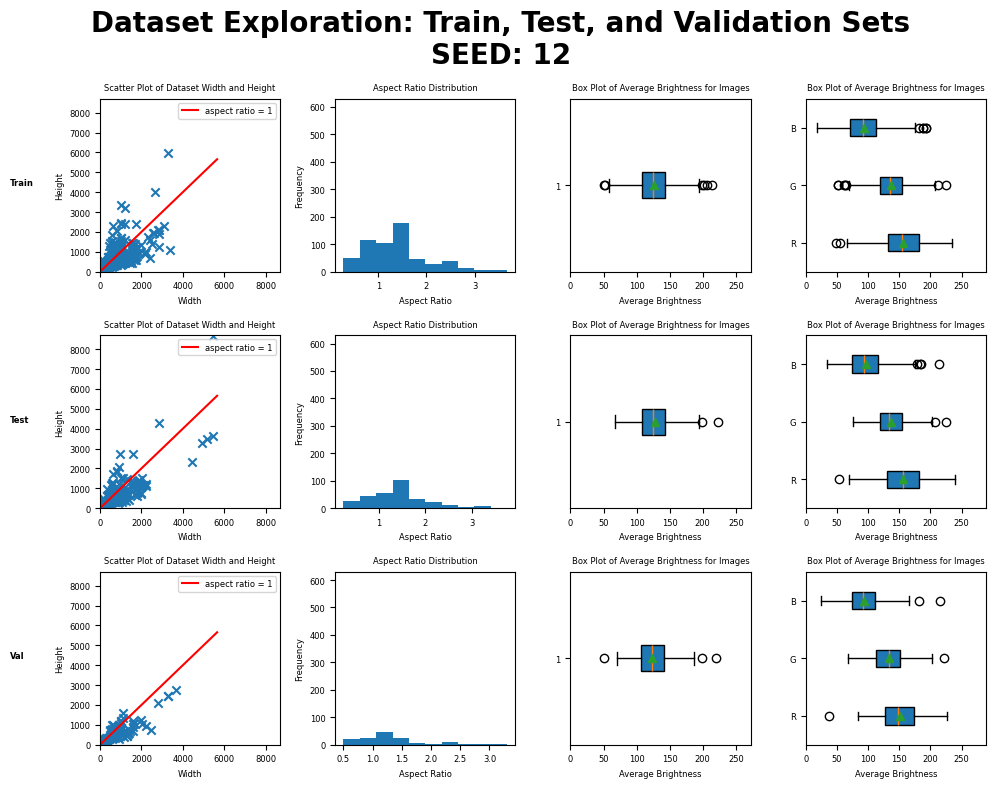

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'PadPakBung': 91, 'FriedKale': 166, 'BooPadPongali': 180, 'MassamanGai': 143}
Testing files per class: {'MassamanGai': 78, 'FriedKale': 88, 'PadPakBung': 35, 'BooPadPongali': 110}
Validation files per class: {'BooPadPongali': 42, 'FriedKale': 57, 'PadPakBung': 20, 'MassamanGai': 26}


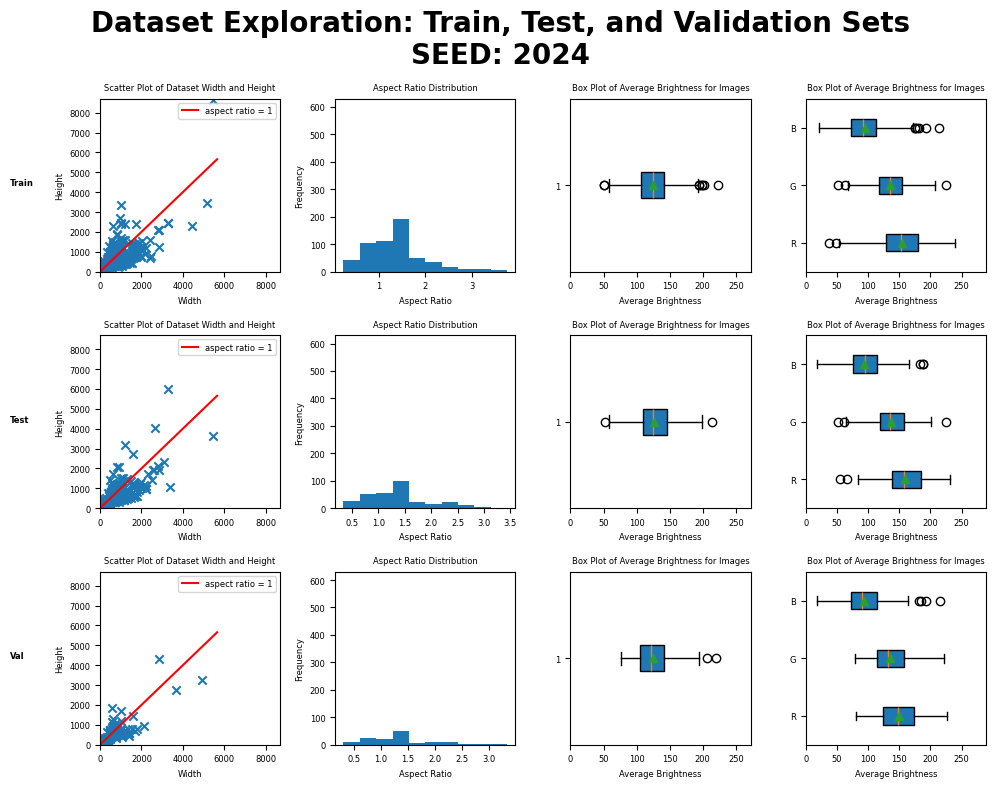

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 176, 'BooPadPongali': 193, 'PadPakBung': 86, 'MassamanGai': 125}
Testing files per class: {'BooPadPongali': 90, 'FriedKale': 94, 'MassamanGai': 84, 'PadPakBung': 43}
Validation files per class: {'BooPadPongali': 49, 'MassamanGai': 38, 'FriedKale': 41, 'PadPakBung': 17}


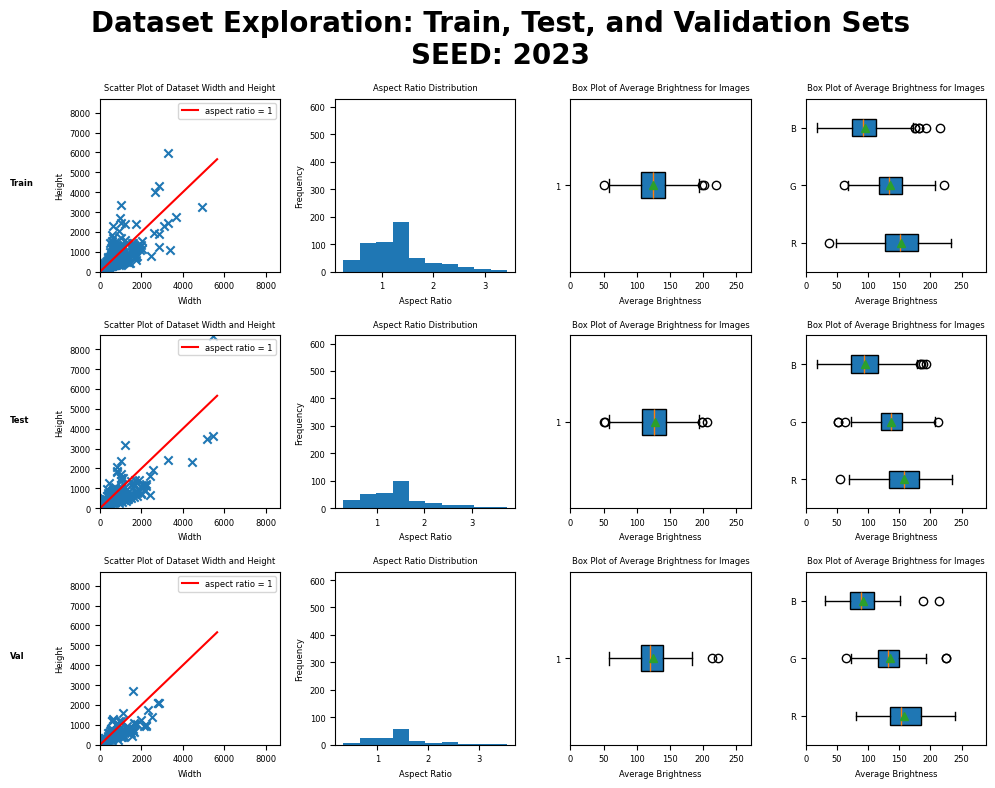

In [ ]:
dataset_dir = "/content/train"
summary(dataset_dir,12)
summary(dataset_dir,2024)
summary(dataset_dir,2023)


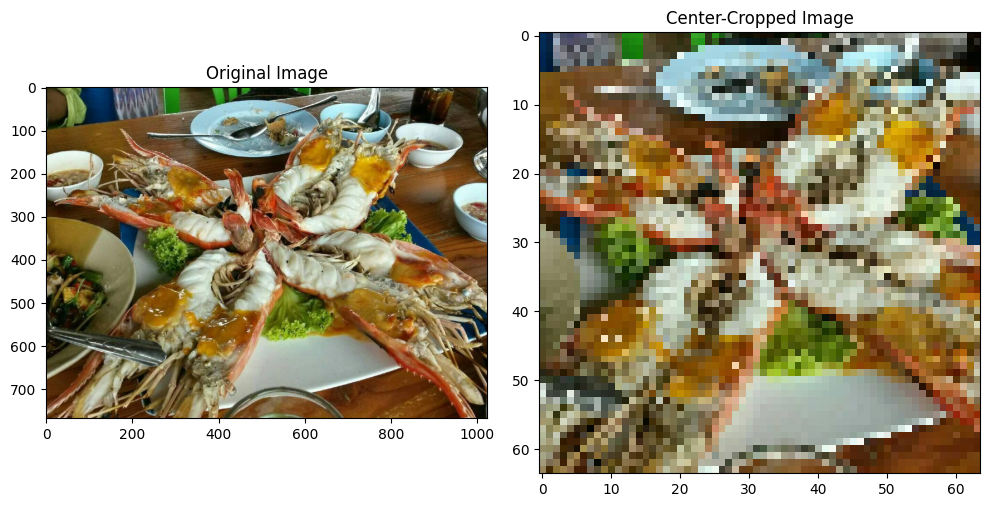

In [ ]:
og_img = cv2.imread('/content/THFOOD4/GoongPao/091.jpg')
og_img = cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)
img = center_crop_image(og_img,(64,64))
ig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(og_img)
ax[0].set_title('Original Image')

# Display the center-cropped image
ax[1].imshow(img)
ax[1].set_title('Center-Cropped Image')


plt.tight_layout()
plt.show()

In [ ]:
seed = 1690
dataset_dir = "/content/train"
train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)

copy_files_to_new_folders(f'/content/seed{seed}', train_files, test_files, val_files)

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'BooPadPongali': 180, 'MassamanGai': 141, 'PadPakBung': 79}
Testing files per class: {'BooPadPongali': 106, 'FriedKale': 88, 'MassamanGai': 69, 'PadPakBung': 48}
Validation files per class: {'BooPadPongali': 46, 'MassamanGai': 37, 'FriedKale': 43, 'PadPakBung': 19}


---

---

In [ ]:
train_dataset = load_data('/content/seed1690/train', is_test=False)
val_dataset   = load_data('/content/seed1690/val',   is_test=True)
test_dataset  = load_data('/content/seed1690/test',  is_test=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


class_names = train_dataset.classes
num_classes = len(class_names)

📃 Dataset: /content/seed1690/train
	Number of images in class BooPadPongali: 180
	Number of images in class FriedKale: 180
	Number of images in class MassamanGai: 141
	Number of images in class PadPakBung: 79
	Number of samples: 580

📃 Dataset: /content/seed1690/val
	Number of images in class BooPadPongali: 46
	Number of images in class FriedKale: 43
	Number of images in class MassamanGai: 37
	Number of images in class PadPakBung: 19
	Number of samples: 145

📃 Dataset: /content/seed1690/test
	Number of images in class BooPadPongali: 106
	Number of images in class FriedKale: 88
	Number of images in class MassamanGai: 69
	Number of images in class PadPakBung: 48
	Number of samples: 311



In [ ]:
def get_resnet18(num_classes, feature_extract=True):
    """
    คืนค่าเป็น ResNet18 ที่ pretrained บน ImageNet
    ถ้า feature_extract=True จะ freeze backbone (ไม่อัปเดต weights) ยกเว้น fc layer สุดท้าย
    """
    model = models.resnet18(pretrained=True)
    if feature_extract:

        for param in model.parameters():
            param.requires_grad = False


    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


model = get_resnet18(num_classes=num_classes, feature_extract=True).to(device)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    ถ้า feature_extracting=True: freeze ทุกเลเยอร์ เว้นแต่ final fc
    ถ้า feature_extracting=False: freezeจนถึง layer3 และให้ layer4+fc เรียนรู้ต่อ
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:

        for name, param in model.named_parameters():
            if not name.startswith("layer4") and not name.startswith("fc"):
                param.requires_grad = False
            else:
                param.requires_grad = True

def k_fold_cross_validation(model_fn, dataset, optimizer_class, optimizer_params,
                            num_folds=3, num_epochs=25, batch_size=16, device=None):
    """
    model_fn: ฟังก์ชันสร้างโมเดล เช่น get_resnet18
    dataset:  train_dataset (ImageFolder)
    optimizer_class: torch.optim optimizer class (e.g. torch.optim.Adam)
    optimizer_params: dict ของพารามิเตอร์ให้ optimizer (e.g. {'lr':1e-5})
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("🤖 Training on", device)

    targets = np.array(dataset.targets)
    class_counts = np.array([np.sum(targets == i) for i in range(len(dataset.classes))])
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print("Class counts:", class_counts)
    print("Class weights:", class_weights)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\n🔀 Fold {fold+1}/{num_folds}")

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,
                                  num_workers=2, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler,
                                  num_workers=2, pin_memory=True)


        model = model_fn(num_classes=len(dataset.classes), feature_extract=False).to(device)

        set_parameter_requires_grad(model, feature_extracting=False)


        params_to_update = [p for p in model.parameters() if p.requires_grad]
        optimizer = optimizer_class(params_to_update, **optimizer_params)
        loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)

        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(model.state_dict())

        for epoch in range(num_epochs):

            model.train()
            running_train_loss = 0.0
            running_train_correct = 0
            all_train_labels = []
            all_train_preds = []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                running_train_correct += (preds == labels).sum().item()
                all_train_labels.extend(labels.cpu().tolist())
                all_train_preds.extend(preds.cpu().tolist())

            epoch_train_loss = running_train_loss / len(train_idx)
            epoch_train_acc = running_train_correct / len(train_idx)
            epoch_train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")

            model.eval()
            running_val_loss = 0.0
            running_val_correct = 0
            all_val_labels = []
            all_val_preds = []

            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)

                    running_val_loss += loss.item() * images.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_val_correct += (preds == labels).sum().item()
                    all_val_labels.extend(labels.cpu().tolist())
                    all_val_preds.extend(preds.cpu().tolist())

            epoch_val_loss = running_val_loss / len(val_idx)
            epoch_val_acc = running_val_correct / len(val_idx)
            epoch_val_f1 = f1_score(all_val_labels, all_val_preds, average="macro")

            print(
                f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} F1: {epoch_train_f1:.4f} | "
                f"Val   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f} F1: {epoch_val_f1:.4f}"
            )

            if epoch_val_f1 > best_val_f1:
                best_val_f1 = epoch_val_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        fold_metrics.append({
            'fold': fold+1,
            'best_val_f1': best_val_f1
        })
        model.load_state_dict(best_model_wts)

    avg_val_f1 = np.mean([m['best_val_f1'] for m in fold_metrics])
    print(f"\n🔎 Average Best Validation F1 over {num_folds} folds: {avg_val_f1:.4f}\n")

    return fold_metrics, avg_val_f1


In [ ]:
optimizer_params = {'lr': 5e-5}
num_folds      = 3
num_epochs     = 25
batch_size     = 16

fold_metrics, avg_val_f1 = k_fold_cross_validation(
    get_resnet18,
    train_dataset,
    torch.optim.Adam,
    optimizer_params,
    num_folds=num_folds,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device
)

print("---- Fold Results ----")
for m in fold_metrics:
    print(f"Fold {m['fold']}: Best Val F1 = {m['best_val_f1']:.4f}")
print(f"Average Best Val F1 (over {num_folds} folds): {avg_val_f1:.4f}")


🤖 Training on cuda
Class counts: [180 180 141  79]
Class weights: [0.72006206 0.72006206 0.91922816 1.64064773]

🔀 Fold 1/3


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1 Epoch 1/25 | Train Loss: 1.2391 Acc: 0.4534 F1: 0.3850 | Val   Loss: 0.9239 Acc: 0.5773 F1: 0.5636
Fold 1 Epoch 2/25 | Train Loss: 0.7374 Acc: 0.7021 F1: 0.6800 | Val   Loss: 0.6321 Acc: 0.7629 F1: 0.7573
Fold 1 Epoch 3/25 | Train Loss: 0.6618 Acc: 0.7358 F1: 0.7141 | Val   Loss: 0.6173 Acc: 0.7216 F1: 0.7131
Fold 1 Epoch 4/25 | Train Loss: 0.5120 Acc: 0.8161 F1: 0.8056 | Val   Loss: 0.5699 Acc: 0.7526 F1: 0.7536
Fold 1 Epoch 5/25 | Train Loss: 0.4215 Acc: 0.8549 F1: 0.8459 | Val   Loss: 0.4879 Acc: 0.7732 F1: 0.7761
Fold 1 Epoch 6/25 | Train Loss: 0.4072 Acc: 0.8394 F1: 0.8276 | Val   Loss: 0.4866 Acc: 0.7371 F1: 0.7396
Fold 1 Epoch 7/25 | Train Loss: 0.3934 Acc: 0.8756 F1: 0.8718 | Val   Loss: 0.4336 Acc: 0.7938 F1: 0.7922
Fold 1 Epoch 8/25 | Train Loss: 0.3653 Acc: 0.8575 F1: 0.8465 | Val   Loss: 0.4342 Acc: 0.8041 F1: 0.8036
Fold 1 Epoch 9/25 | Train Loss: 0.3619 Acc: 0.8886 F1: 0.8712 | Val   Loss: 0.4209 Acc: 0.8351 F1: 0.8349
Fold 1 Epoch 10/25 | Train Loss: 0.3610 Acc: 0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2 Epoch 1/25 | Train Loss: 1.0605 Acc: 0.5245 F1: 0.5150 | Val   Loss: 0.7442 Acc: 0.6891 F1: 0.6917
Fold 2 Epoch 2/25 | Train Loss: 0.7043 Acc: 0.6899 F1: 0.6873 | Val   Loss: 0.6237 Acc: 0.7409 F1: 0.7344
Fold 2 Epoch 3/25 | Train Loss: 0.5862 Acc: 0.7623 F1: 0.7522 | Val   Loss: 0.5156 Acc: 0.7979 F1: 0.7816
Fold 2 Epoch 4/25 | Train Loss: 0.4863 Acc: 0.7984 F1: 0.7967 | Val   Loss: 0.4948 Acc: 0.7876 F1: 0.7712
Fold 2 Epoch 5/25 | Train Loss: 0.4498 Acc: 0.8372 F1: 0.8292 | Val   Loss: 0.4671 Acc: 0.7927 F1: 0.7787
Fold 2 Epoch 6/25 | Train Loss: 0.4362 Acc: 0.8295 F1: 0.8245 | Val   Loss: 0.4532 Acc: 0.8446 F1: 0.8383
Fold 2 Epoch 7/25 | Train Loss: 0.4453 Acc: 0.8114 F1: 0.8060 | Val   Loss: 0.4132 Acc: 0.8290 F1: 0.8325
Fold 2 Epoch 8/25 | Train Loss: 0.3711 Acc: 0.8656 F1: 0.8572 | Val   Loss: 0.4091 Acc: 0.8290 F1: 0.8228
Fold 2 Epoch 9/25 | Train Loss: 0.3347 Acc: 0.8579 F1: 0.8547 | Val   Loss: 0.3830 Acc: 0.8653 F1: 0.8474
Fold 2 Epoch 10/25 | Train Loss: 0.3519 Acc: 0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3 Epoch 1/25 | Train Loss: 1.1301 Acc: 0.4393 F1: 0.4375 | Val   Loss: 0.8262 Acc: 0.6684 F1: 0.6467
Fold 3 Epoch 2/25 | Train Loss: 0.7183 Acc: 0.7313 F1: 0.7271 | Val   Loss: 0.6237 Acc: 0.7824 F1: 0.7589
Fold 3 Epoch 3/25 | Train Loss: 0.5527 Acc: 0.7855 F1: 0.7831 | Val   Loss: 0.5383 Acc: 0.7720 F1: 0.7550
Fold 3 Epoch 4/25 | Train Loss: 0.5173 Acc: 0.8114 F1: 0.8120 | Val   Loss: 0.4599 Acc: 0.8187 F1: 0.7928
Fold 3 Epoch 5/25 | Train Loss: 0.4930 Acc: 0.7959 F1: 0.7952 | Val   Loss: 0.4720 Acc: 0.8083 F1: 0.7908
Fold 3 Epoch 6/25 | Train Loss: 0.4396 Acc: 0.8191 F1: 0.8182 | Val   Loss: 0.4498 Acc: 0.8342 F1: 0.8174
Fold 3 Epoch 7/25 | Train Loss: 0.4818 Acc: 0.8062 F1: 0.7985 | Val   Loss: 0.3935 Acc: 0.8342 F1: 0.8135
Fold 3 Epoch 8/25 | Train Loss: 0.4483 Acc: 0.8346 F1: 0.8270 | Val   Loss: 0.4017 Acc: 0.8549 F1: 0.8328
Fold 3 Epoch 9/25 | Train Loss: 0.3773 Acc: 0.8630 F1: 0.8589 | Val   Loss: 0.4503 Acc: 0.8601 F1: 0.8465
Fold 3 Epoch 10/25 | Train Loss: 0.3381 Acc: 0

In [ ]:
full_train_dataset = ConcatDataset([train_dataset, val_dataset])
print("Full training size:", len(full_train_dataset))


targets = np.array(train_dataset.targets)
class_counts = np.array([np.sum(targets == i) for i in range(len(train_dataset.classes))])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

num_total = len(full_train_dataset)
indices = list(range(num_total))
np.random.seed(42)
np.random.shuffle(indices)
split = int(np.floor(0.1 * num_total))
val_indices = indices[:split]
train_indices = indices[split:]

train_sampler_fs = SubsetRandomSampler(train_indices)
val_sampler_fs   = SubsetRandomSampler(val_indices)


batch_size_fs = 16
train_loader_fs = DataLoader(full_train_dataset, batch_size=batch_size_fs,
                             sampler=train_sampler_fs, num_workers=2, pin_memory=True)
val_loader_fs   = DataLoader(full_train_dataset, batch_size=batch_size_fs,
                             sampler=val_sampler_fs, num_workers=2, pin_memory=True)
dataloaders_fs  = {'train': train_loader_fs, 'val': val_loader_fs}
dataset_sizes_fs = {'train': len(train_indices), 'val': len(val_indices)}
model_full = get_resnet18(num_classes=num_classes, feature_extract=False).to(device)
set_parameter_requires_grad(model_full, feature_extracting=False)


criterion  = nn.CrossEntropyLoss(weight=weight_tensor)
params_to_update = [p for p in model_full.parameters() if p.requires_grad]
optimizer  = optim.Adam(params_to_update, lr=5e-5)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3, verbose=True)


def train_full_with_earlystop(model, dataloaders, dataset_sizes,
                              criterion, optimizer, scheduler,
                              num_epochs=30, early_stop_patience=5, device=None):
    """
    ฝึกบน train_main (90%) และ validate บน small-val (10%) เพื่อ EarlyStopping
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\n--- Full Training Epoch {epoch+1}/{num_epochs} ---")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            loader = dataloaders[phase]
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().tolist())
                all_preds.extend(preds.cpu().tolist())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects / dataset_sizes[phase]
            epoch_f1   = f1_score(all_labels, all_preds, average='macro')

            print(f"{phase.capitalize()} | Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), "best_full_model.pth")
                else:
                    epochs_no_improve += 1

        print('-'*40)
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping: Val F1 ไม่ดีขึ้นเกิน {early_stop_patience} epochs")
            break

    model.load_state_dict(best_model_wts)
    print(f"\n>> Best small-Val F1: {best_val_f1:.4f}")
    return model

model_full_trained = train_full_with_earlystop(
    model_full,
    dataloaders_fs,
    dataset_sizes_fs,
    criterion,
    optimizer,
    scheduler,
    num_epochs=30,
    early_stop_patience=5,
    device=device
)


Full training size: 725


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Full Training Epoch 1/30 ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train | Loss: 0.9400 Acc: 0.6064 F1: 0.6006
Val | Loss: 0.6824 Acc: 0.6806 F1: 0.6756
----------------------------------------

--- Full Training Epoch 2/30 ---
Train | Loss: 0.5346 Acc: 0.7979 F1: 0.7915
Val | Loss: 0.4528 Acc: 0.8333 F1: 0.8237
----------------------------------------

--- Full Training Epoch 3/30 ---
Train | Loss: 0.4353 Acc: 0.8591 F1: 0.8494
Val | Loss: 0.5164 Acc: 0.8056 F1: 0.8027
----------------------------------------

--- Full Training Epoch 4/30 ---
Train | Loss: 0.4003 Acc: 0.8285 F1: 0.8170
Val | Loss: 0.3908 Acc: 0.8472 F1: 0.8454
----------------------------------------

--- Full Training Epoch 5/30 ---
Train | Loss: 0.3677 Acc: 0.8760 F1: 0.8672
Val | Loss: 0.3627 Acc: 0.8611 F1: 0.8409
----------------------------------------

--- Full Training Epoch 6/30 ---
Train | Loss: 0.3380 Acc: 0.8729 F1: 0.8600
Val | Loss: 0.3846 Acc: 0.8750 F1: 0.8609
----------------------------------------

--- Full Training Epoch 7/30 ---
Train | Loss: 0.3243 Acc: 0.8867 F

In [ ]:
model_infer = get_resnet18(num_classes=num_classes, feature_extract=False)

set_parameter_requires_grad(model_infer, feature_extracting=False)
model_infer.load_state_dict(torch.load("best_full_model.pth"))
model_infer = model_infer.to(device)
model_infer.eval()

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.samples = []

        for class_name in sorted(os.listdir(img_dir)):
            class_folder = os.path.join(img_dir, class_name)
            if os.path.isdir(class_folder):
                for fname in sorted(os.listdir(class_folder)):
                    self.samples.append((os.path.join(class_folder, fname), fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, fname = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, fname

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_dataset_custom = TestDataset(
    img_dir='/content/seed1690/test',
    transform=test_transform
)
test_loader_custom = DataLoader(test_dataset_custom, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

preds = []
with torch.no_grad():
    for images, fnames in test_loader_custom:
        images = images.to(device)
        outputs = model_infer(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().tolist()
        for fname, p in zip(fnames, predicted):
            preds.append((fname, p))

df = pd.DataFrame(preds, columns=['filename', 'pred_label_index'])
df['pred_label_name'] = df['pred_label_index'].map({i: name for i, name in enumerate(class_names)})
df.to_csv("predictions.csv", index=False)
print("Saved predictions.csv with", len(df), "rows")


Saved predictions.csv with 311 rows
